In [1]:
#!pip install yfinance
#!pip install pandas
#!pip install chardet
#!pip install pandas_datareader
#!pip install YahooFinancials
#!pip install scikit-learn
#!pip install --upgrade yfinance
#!pip install tejapi
#!pip install xlsxwirter
import os
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import pandas_datareader as pdr
import chardet 
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# 年份處理與資料初整理

In [2]:
# 指定檔案路徑
file_path = r"E:\碩士\財務工程(二)\FZ分數1.xlsx"

# 讀取 Excel 檔案
basic_data = pd.read_excel(file_path)

basic_data["現金增資(仟股)"] = basic_data["現金增資(仟股)"].fillna(0)

basic_data["年月"] = basic_data["年月"].astype(str).str.slice(0, 4)

basic_data["股價"] = basic_data["當季季底P/B"] * basic_data["每股淨值(A)"]

# 假設 basic_data 已經讀取進來
basic_data['報酬率'] = basic_data.groupby('公司')['股價'].pct_change(fill_method=None).ffill()

# 移除 "收盤價(元)" 欄位
basic_data = basic_data.drop(columns=['股價'])

display(basic_data)

,公司,年月,流動資產,流動負債,資產總額,保留盈餘,稅前息前淨利,季底普通股市值,負債總額,營業收入淨額,歸屬母公司淨利（損）,來自營運之現金流量,現金增資(仟股),營業毛利,當季季底P/B,每股淨值(A),報酬率
0,2301 光寶科,2013,150430691.0,111356983.0,212361486.0,21463386.0,12228610.0,111260475.0,133124331.0,213214297.0,8754848.0,20688338.0,0.0,30500594.0,1.52,31.80,NaN
1,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,20959086.0,8421506.0,85236897.0,137361191.0,230631974.0,6460808.0,14131417.0,0.0,28248114.0,1.14,32.38,-0.236321
2,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,23366328.0,10585356.0,74367457.0,129970270.0,216928734.0,7222899.0,15552262.0,0.0,28141217.0,0.98,32.92,-0.126015
3,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,27496140.0,13199864.0,114252136.0,131576352.0,229571758.0,9416351.0,14512514.0,0.0,31258268.0,1.50,32.67,0.518989
4,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,23219598.0,3975438.0,95445200.0,116228328.0,214564322.0,2629334.0,11153180.0,0.0,27709817.0,1.35,30.34,-0.164187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9912 偉聯,2020,360049.0,260527.0,691393.0,-18828.0,-34686.0,451432.0,271818.0,538991.0,-38233.0,79243.0,0.0,182143.0,1.08,8.22,-0.013161
707,9912 偉聯,2021,441796.0,334589.0,764082.0,-587.0,29144.0,562627.0,343497.0,632260.0,18241.0,-47312.0,0.0,215586.0,1.34,8.11,0.224137
708,9912 偉聯,2022,426643.0,332239.0,770953.0,-14346.0,-24377.0,498968.0,339772.0,594422.0,-13759.0,-33671.0,0.0,188983.0,1.19,8.10,-0.113035
709,9912 偉聯,2023,400578.0,308373.0,794605.0,27724.0,-39499.0,596354.0,314116.0,510587.0,-20637.0,68206.0,0.0,199660.0,1.26,9.03,0.180392


# 移除2013年至2024年內上市或者年份不完整的公司

In [3]:
import pandas as pd

# 定義完整的年份範圍
full_years = set(map(str, range(2013, 2025)))

# 取得每間公司的年份清單
company_years = basic_data.groupby("公司")["年月"].apply(set)

# 找出缺少年份的公司
missing_years = {company: full_years - years for company, years in company_years.items() if full_years - years}

# 列出被刪除的公司與缺少的年份
print(f"原本公司數: {len(company_years)}")

for company, missing in missing_years.items():
    print(f"刪除公司: {company}, 缺少年份: {sorted(missing)}")

# 只保留年份完整的公司
valid_companies = set(company_years.keys()) - set(missing_years.keys())
filtered_data = basic_data[basic_data["公司"].isin(valid_companies)]

# 顯示刪除後的公司數
print(f"刪除後的公司數: {len(valid_companies)}")

display(filtered_data)

原本公司數: 61
刪除公司: 2380 虹光, 缺少年份: ['2024']
刪除公司: 2405 輔信, 缺少年份: ['2024']
刪除公司: 2425 承啟, 缺少年份: ['2024']
刪除公司: 3494 誠研, 缺少年份: ['2024']
刪除公司: 3701 大眾控, 缺少年份: ['2024']
刪除公司: 3712 永崴投控, 缺少年份: ['2013', '2014', '2015', '2016']
刪除公司: 6928 攸泰科技, 缺少年份: ['2013', '2014', '2015', '2016', '2017']
刪除公司: 6933 AMAX-KY, 缺少年份: ['2013', '2014', '2015', '2016', '2017', '2018', '2019']
刪除後的公司數: 53


,公司,年月,流動資產,流動負債,資產總額,保留盈餘,稅前息前淨利,季底普通股市值,負債總額,營業收入淨額,歸屬母公司淨利（損）,來自營運之現金流量,現金增資(仟股),營業毛利,當季季底P/B,每股淨值(A),報酬率
0,2301 光寶科,2013,150430691.0,111356983.0,212361486.0,21463386.0,12228610.0,111260475.0,133124331.0,213214297.0,8754848.0,20688338.0,0.0,30500594.0,1.52,31.80,NaN
1,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,20959086.0,8421506.0,85236897.0,137361191.0,230631974.0,6460808.0,14131417.0,0.0,28248114.0,1.14,32.38,-0.236321
2,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,23366328.0,10585356.0,74367457.0,129970270.0,216928734.0,7222899.0,15552262.0,0.0,28141217.0,0.98,32.92,-0.126015
3,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,27496140.0,13199864.0,114252136.0,131576352.0,229571758.0,9416351.0,14512514.0,0.0,31258268.0,1.50,32.67,0.518989
4,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,23219598.0,3975438.0,95445200.0,116228328.0,214564322.0,2629334.0,11153180.0,0.0,27709817.0,1.35,30.34,-0.164187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9912 偉聯,2020,360049.0,260527.0,691393.0,-18828.0,-34686.0,451432.0,271818.0,538991.0,-38233.0,79243.0,0.0,182143.0,1.08,8.22,-0.013161
707,9912 偉聯,2021,441796.0,334589.0,764082.0,-587.0,29144.0,562627.0,343497.0,632260.0,18241.0,-47312.0,0.0,215586.0,1.34,8.11,0.224137
708,9912 偉聯,2022,426643.0,332239.0,770953.0,-14346.0,-24377.0,498968.0,339772.0,594422.0,-13759.0,-33671.0,0.0,188983.0,1.19,8.10,-0.113035
709,9912 偉聯,2023,400578.0,308373.0,794605.0,27724.0,-39499.0,596354.0,314116.0,510587.0,-20637.0,68206.0,0.0,199660.0,1.26,9.03,0.180392


# 缺失值處理

In [4]:
import pandas as pd

# 定義需要檢查缺失值的列
columns_to_check = [
    '流動資產', '流動負債', '資產總額', '保留盈餘', '稅前息前淨利', 
    '季底普通股市值', '負債總額', '營業收入淨額', '歸屬母公司淨利（損）', 
    '來自營運之現金流量', '現金增資(仟股)', '營業毛利'
]

# 需要檢查的 2011 年度列
columns_to_check_2011 = [
    '流動資產', '流動負債', '資產總額', '負債總額', '營業毛利', 
    '營業收入淨額', '歸屬母公司淨利（損）'
]

# 取得每間公司的年份清單
company_years = filtered_data.groupby("公司")["年月"].apply(set)

# 定義完整的年份範圍
full_years = set(map(str, range(2013, 2025)))

# 找出缺少資料的公司及缺少的年份
missing_years = {}
missing_columns_details = {}

for company, years in company_years.items():
    for year in years:
        if int(year) == 2013:
            # 2011年只檢查特定列的缺失值
            missing_columns = filtered_data[(filtered_data["公司"] == company) & (filtered_data["年月"] == year)][columns_to_check_2011].isna()
        else:
            # 其他年份檢查全部列的缺失值
            missing_columns = filtered_data[(filtered_data["公司"] == company) & (filtered_data["年月"] == year)][columns_to_check].isna()
        
        # 檢查哪些列是缺失的
        missing_columns_list = missing_columns.columns[missing_columns.any()].tolist()
        
        if missing_columns_list:
            if company not in missing_years:
                missing_years[company] = []
            missing_years[company].append(year)
            missing_columns_details[company] = missing_columns_list

# 列出原本的公司數
print(f"原本公司數: {len(company_years)}")

# 列出缺少資料的公司、年份以及缺失的財報項目
for company, missing in missing_years.items():
    print(f"刪除公司: {company}, 缺少年份: {sorted(missing)}")
    print(f"缺少的財報項目: {missing_columns_details[company]}")

# 只保留有效的公司
valid_companies = set(company_years.keys()) - set(missing_years.keys())
filtered_data = filtered_data[filtered_data["公司"].isin(valid_companies)]

# 顯示刪除後的公司數
print(f"刪除後的公司數: {len(valid_companies)}")

# 顯示過濾後的資料
display(filtered_data)



原本公司數: 53
刪除公司: 6414 樺漢, 缺少年份: ['2024']
缺少的財報項目: ['流動資產', '流動負債', '資產總額', '保留盈餘', '稅前息前淨利', '季底普通股市值', '負債總額', '營業收入淨額', '歸屬母公司淨利（損）', '來自營運之現金流量', '營業毛利']
刪除公司: 6579 研揚, 缺少年份: ['2014', '2015']
缺少的財報項目: ['季底普通股市值']
刪除公司: 6591 動力-KY, 缺少年份: ['2014', '2015']
缺少的財報項目: ['季底普通股市值']
刪除公司: 6669 緯穎, 缺少年份: ['2013', '2014', '2015', '2016']
缺少的財報項目: ['季底普通股市值']
刪除後的公司數: 49


,公司,年月,流動資產,流動負債,資產總額,保留盈餘,稅前息前淨利,季底普通股市值,負債總額,營業收入淨額,歸屬母公司淨利（損）,來自營運之現金流量,現金增資(仟股),營業毛利,當季季底P/B,每股淨值(A),報酬率
0,2301 光寶科,2013,150430691.0,111356983.0,212361486.0,21463386.0,12228610.0,111260475.0,133124331.0,213214297.0,8754848.0,20688338.0,0.0,30500594.0,1.52,31.80,NaN
1,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,20959086.0,8421506.0,85236897.0,137361191.0,230631974.0,6460808.0,14131417.0,0.0,28248114.0,1.14,32.38,-0.236321
2,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,23366328.0,10585356.0,74367457.0,129970270.0,216928734.0,7222899.0,15552262.0,0.0,28141217.0,0.98,32.92,-0.126015
3,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,27496140.0,13199864.0,114252136.0,131576352.0,229571758.0,9416351.0,14512514.0,0.0,31258268.0,1.50,32.67,0.518989
4,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,23219598.0,3975438.0,95445200.0,116228328.0,214564322.0,2629334.0,11153180.0,0.0,27709817.0,1.35,30.34,-0.164187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9912 偉聯,2020,360049.0,260527.0,691393.0,-18828.0,-34686.0,451432.0,271818.0,538991.0,-38233.0,79243.0,0.0,182143.0,1.08,8.22,-0.013161
707,9912 偉聯,2021,441796.0,334589.0,764082.0,-587.0,29144.0,562627.0,343497.0,632260.0,18241.0,-47312.0,0.0,215586.0,1.34,8.11,0.224137
708,9912 偉聯,2022,426643.0,332239.0,770953.0,-14346.0,-24377.0,498968.0,339772.0,594422.0,-13759.0,-33671.0,0.0,188983.0,1.19,8.10,-0.113035
709,9912 偉聯,2023,400578.0,308373.0,794605.0,27724.0,-39499.0,596354.0,314116.0,510587.0,-20637.0,68206.0,0.0,199660.0,1.26,9.03,0.180392


# 淨值比排序篩股(可以調篩選數量)

In [5]:
import pandas as pd

# 按公司分組，取 2024 年的當季季底P/B，並進行排序
top_30_companies = filtered_data[filtered_data["年月"] == "2024"].groupby("公司")["當季季底P/B"].min().nsmallest(30)

# 取得最小的 30 家公司的名稱
top_30_company_names = top_30_companies.index.tolist()

# 過濾出這些公司在所有年份的資料
filtered_data_top_30 = filtered_data[filtered_data["公司"].isin(top_30_company_names)]

# 顯示過濾後的資料
display(filtered_data_top_30)


,公司,年月,流動資產,流動負債,資產總額,保留盈餘,稅前息前淨利,季底普通股市值,負債總額,營業收入淨額,歸屬母公司淨利（損）,來自營運之現金流量,現金增資(仟股),營業毛利,當季季底P/B,每股淨值(A),報酬率
0,2301 光寶科,2013,150430691.0,111356983.0,212361486.0,21463386.0,12228610.0,111260475.0,133124331.0,213214297.0,8754848.0,20688338.0,0.0,30500594.0,1.52,31.80,NaN
1,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,20959086.0,8421506.0,85236897.0,137361191.0,230631974.0,6460808.0,14131417.0,0.0,28248114.0,1.14,32.38,-0.236321
2,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,23366328.0,10585356.0,74367457.0,129970270.0,216928734.0,7222899.0,15552262.0,0.0,28141217.0,0.98,32.92,-0.126015
3,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,27496140.0,13199864.0,114252136.0,131576352.0,229571758.0,9416351.0,14512514.0,0.0,31258268.0,1.50,32.67,0.518989
4,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,23219598.0,3975438.0,95445200.0,116228328.0,214564322.0,2629334.0,11153180.0,0.0,27709817.0,1.35,30.34,-0.164187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9912 偉聯,2020,360049.0,260527.0,691393.0,-18828.0,-34686.0,451432.0,271818.0,538991.0,-38233.0,79243.0,0.0,182143.0,1.08,8.22,-0.013161
707,9912 偉聯,2021,441796.0,334589.0,764082.0,-587.0,29144.0,562627.0,343497.0,632260.0,18241.0,-47312.0,0.0,215586.0,1.34,8.11,0.224137
708,9912 偉聯,2022,426643.0,332239.0,770953.0,-14346.0,-24377.0,498968.0,339772.0,594422.0,-13759.0,-33671.0,0.0,188983.0,1.19,8.10,-0.113035
709,9912 偉聯,2023,400578.0,308373.0,794605.0,27724.0,-39499.0,596354.0,314116.0,510587.0,-20637.0,68206.0,0.0,199660.0,1.26,9.03,0.180392


# ZF分數分割

In [6]:
# 第一組列名稱
columns_group_1 = [
    '公司', '年月', '流動資產', '流動負債', '資產總額', '保留盈餘', '稅前息前淨利', 
    '季底普通股市值', '負債總額', '營業收入淨額',"報酬率","當季季底P/B"
]

# 第二組列名稱
columns_group_2 = [
    '公司', '年月', '流動資產', '流動負債', '資產總額', '負債總額', '營業收入淨額', 
    '歸屬母公司淨利（損）', '來自營運之現金流量', '現金增資(仟股)', '營業毛利',"報酬率","當季季底P/B"
]

# 分成兩組資料
z_score_test = filtered_data[columns_group_1]
f_score_test = filtered_data[columns_group_2]

# 顯示兩組資料
display(z_score_test)
display(f_score_test)


,公司,年月,流動資產,流動負債,資產總額,保留盈餘,稅前息前淨利,季底普通股市值,負債總額,營業收入淨額,報酬率,當季季底P/B
0,2301 光寶科,2013,150430691.0,111356983.0,212361486.0,21463386.0,12228610.0,111260475.0,133124331.0,213214297.0,NaN,1.52
1,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,20959086.0,8421506.0,85236897.0,137361191.0,230631974.0,-0.236321,1.14
2,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,23366328.0,10585356.0,74367457.0,129970270.0,216928734.0,-0.126015,0.98
3,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,27496140.0,13199864.0,114252136.0,131576352.0,229571758.0,0.518989,1.50
4,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,23219598.0,3975438.0,95445200.0,116228328.0,214564322.0,-0.164187,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...
706,9912 偉聯,2020,360049.0,260527.0,691393.0,-18828.0,-34686.0,451432.0,271818.0,538991.0,-0.013161,1.08
707,9912 偉聯,2021,441796.0,334589.0,764082.0,-587.0,29144.0,562627.0,343497.0,632260.0,0.224137,1.34
708,9912 偉聯,2022,426643.0,332239.0,770953.0,-14346.0,-24377.0,498968.0,339772.0,594422.0,-0.113035,1.19
709,9912 偉聯,2023,400578.0,308373.0,794605.0,27724.0,-39499.0,596354.0,314116.0,510587.0,0.180392,1.26


,公司,年月,流動資產,流動負債,資產總額,負債總額,營業收入淨額,歸屬母公司淨利（損）,來自營運之現金流量,現金增資(仟股),營業毛利,報酬率,當季季底P/B
0,2301 光寶科,2013,150430691.0,111356983.0,212361486.0,133124331.0,213214297.0,8754848.0,20688338.0,0.0,30500594.0,NaN,1.52
1,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,137361191.0,230631974.0,6460808.0,14131417.0,0.0,28248114.0,-0.236321,1.14
2,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,129970270.0,216928734.0,7222899.0,15552262.0,0.0,28141217.0,-0.126015,0.98
3,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,131576352.0,229571758.0,9416351.0,14512514.0,0.0,31258268.0,0.518989,1.50
4,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,116228328.0,214564322.0,2629334.0,11153180.0,0.0,27709817.0,-0.164187,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9912 偉聯,2020,360049.0,260527.0,691393.0,271818.0,538991.0,-38233.0,79243.0,0.0,182143.0,-0.013161,1.08
707,9912 偉聯,2021,441796.0,334589.0,764082.0,343497.0,632260.0,18241.0,-47312.0,0.0,215586.0,0.224137,1.34
708,9912 偉聯,2022,426643.0,332239.0,770953.0,339772.0,594422.0,-13759.0,-33671.0,0.0,188983.0,-0.113035,1.19
709,9912 偉聯,2023,400578.0,308373.0,794605.0,314116.0,510587.0,-20637.0,68206.0,0.0,199660.0,0.180392,1.26


# Z分數計算

In [7]:
z_score_test=z_score_test.copy()
z_score_test.loc[:, 'Z1'] = (z_score_test['流動資產'] - z_score_test['流動負債']) / z_score_test['資產總額']
z_score_test.loc[:, 'Z2'] = z_score_test['保留盈餘'] / z_score_test['資產總額']
z_score_test.loc[:, 'Z3'] = z_score_test['稅前息前淨利'] / z_score_test['資產總額']
z_score_test.loc[:, 'Z4'] = z_score_test['季底普通股市值'] / z_score_test['負債總額']
z_score_test.loc[:, 'Z5'] = z_score_test['營業收入淨額'] / z_score_test['資產總額']

# 計算 Z 分數
z_score_test['Z分數'] = (
    z_score_test['Z1'] * 1.2 + 
    z_score_test['Z2'] * 1.4 + 
    z_score_test['Z3'] * 3.3 + 
    z_score_test['Z4'] * 0.6 + 
    z_score_test['Z5'] * 0.999
)


display(z_score_test)





,公司,年月,流動資產,流動負債,資產總額,保留盈餘,稅前息前淨利,季底普通股市值,負債總額,營業收入淨額,報酬率,當季季底P/B,Z1,Z2,Z3,Z4,Z5,Z分數
0,2301 光寶科,2013,150430691.0,111356983.0,212361486.0,21463386.0,12228610.0,111260475.0,133124331.0,213214297.0,NaN,1.52,0.183996,0.101070,0.057584,0.835764,1.004016,2.056791
1,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,20959086.0,8421506.0,85236897.0,137361191.0,230631974.0,-0.236321,1.14,0.154397,0.096794,0.038892,0.620531,1.065108,1.885495
2,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,23366328.0,10585356.0,74367457.0,129970270.0,216928734.0,-0.126015,0.98,0.193093,0.111452,0.050490,0.572188,1.034699,1.931338
3,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,27496140.0,13199864.0,114252136.0,131576352.0,229571758.0,0.518989,1.50,0.197304,0.130402,0.062601,0.868333,1.088757,2.234579
4,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,23219598.0,3975438.0,95445200.0,116228328.0,214564322.0,-0.164187,1.35,0.160354,0.122211,0.020924,0.821187,1.129311,2.053463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9912 偉聯,2020,360049.0,260527.0,691393.0,-18828.0,-34686.0,451432.0,271818.0,538991.0,-0.013161,1.08,0.143944,-0.027232,-0.050168,1.660788,0.779573,1.744319
707,9912 偉聯,2021,441796.0,334589.0,764082.0,-587.0,29144.0,562627.0,343497.0,632260.0,0.224137,1.34,0.140308,-0.000768,0.038143,1.637939,0.827477,2.102577
708,9912 偉聯,2022,426643.0,332239.0,770953.0,-14346.0,-24377.0,498968.0,339772.0,594422.0,-0.113035,1.19,0.122451,-0.018608,-0.031619,1.468538,0.771022,1.667920
709,9912 偉聯,2023,400578.0,308373.0,794605.0,27724.0,-39499.0,596354.0,314116.0,510587.0,0.180392,1.26,0.116039,0.034890,-0.049709,1.898515,0.642567,1.805087


# Z分數資料處理

In [8]:
z_score=z_score_test.copy()

# 先轉換 '年月' 為整數
z_score['年月'] = z_score['年月'].astype(int)

# 刪除 2013 年的資料
z_score = z_score[z_score['年月'] > 2013].copy()

display(z_score)

z_score_return=z_score.copy()

z_score_return = z_score_return[["公司", "年月", "報酬率", "Z分數","當季季底P/B"]]

# 針對每個公司，將 "報酬率" 欄位往下移動一格
z_score_return["明年報酬率"] = z_score_return.groupby("公司")["報酬率"].shift(-1)


display(z_score_return)




,公司,年月,流動資產,流動負債,資產總額,保留盈餘,稅前息前淨利,季底普通股市值,負債總額,營業收入淨額,報酬率,當季季底P/B,Z1,Z2,Z3,Z4,Z5,Z分數
1,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,20959086.0,8421506.0,85236897.0,137361191.0,230631974.0,-0.236321,1.14,0.154397,0.096794,0.038892,0.620531,1.065108,1.885495
2,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,23366328.0,10585356.0,74367457.0,129970270.0,216928734.0,-0.126015,0.98,0.193093,0.111452,0.050490,0.572188,1.034699,1.931338
3,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,27496140.0,13199864.0,114252136.0,131576352.0,229571758.0,0.518989,1.50,0.197304,0.130402,0.062601,0.868333,1.088757,2.234579
4,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,23219598.0,3975438.0,95445200.0,116228328.0,214564322.0,-0.164187,1.35,0.160354,0.122211,0.020924,0.821187,1.129311,2.053463
5,2301 光寶科,2018,157984918.0,120612081.0,197136069.0,30545001.0,11659439.0,95445200.0,122457668.0,207109088.0,0.004043,1.34,0.189579,0.154944,0.059144,0.779414,1.050590,2.156779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9912 偉聯,2020,360049.0,260527.0,691393.0,-18828.0,-34686.0,451432.0,271818.0,538991.0,-0.013161,1.08,0.143944,-0.027232,-0.050168,1.660788,0.779573,1.744319
707,9912 偉聯,2021,441796.0,334589.0,764082.0,-587.0,29144.0,562627.0,343497.0,632260.0,0.224137,1.34,0.140308,-0.000768,0.038143,1.637939,0.827477,2.102577
708,9912 偉聯,2022,426643.0,332239.0,770953.0,-14346.0,-24377.0,498968.0,339772.0,594422.0,-0.113035,1.19,0.122451,-0.018608,-0.031619,1.468538,0.771022,1.667920
709,9912 偉聯,2023,400578.0,308373.0,794605.0,27724.0,-39499.0,596354.0,314116.0,510587.0,0.180392,1.26,0.116039,0.034890,-0.049709,1.898515,0.642567,1.805087


,公司,年月,報酬率,Z分數,當季季底P/B,明年報酬率
1,2301 光寶科,2014,-0.236321,1.885495,1.14,-0.126015
2,2301 光寶科,2015,-0.126015,1.931338,0.98,0.518989
3,2301 光寶科,2016,0.518989,2.234579,1.50,-0.164187
4,2301 光寶科,2017,-0.164187,2.053463,1.35,0.004043
5,2301 光寶科,2018,0.004043,2.156779,1.34,0.213094
...,...,...,...,...,...,...
706,9912 偉聯,2020,-0.013161,1.744319,1.08,0.224137
707,9912 偉聯,2021,0.224137,2.102577,1.34,-0.113035
708,9912 偉聯,2022,-0.113035,1.667920,1.19,0.180392
709,9912 偉聯,2023,0.180392,1.805087,1.26,0.056821


# F分數計算

In [9]:
f_score_test = f_score_test.copy()  # 創建副本，避免警告

# 確保數據按公司 & 年份排序
f_score_test = f_score_test.sort_values(by=['公司', '年月']).copy()

# 計算 F1 ~ F9
f_score_test['F1'] = f_score_test['歸屬母公司淨利（損）'] / f_score_test['資產總額']
f_score_test['F2'] = f_score_test['F1'] - f_score_test.groupby('公司')['F1'].shift(1)
f_score_test['F3'] = f_score_test['來自營運之現金流量'] / f_score_test['資產總額']
f_score_test['F4'] = f_score_test['F1'] - f_score_test['F3']

f_score_test['F5'] = (f_score_test['負債總額'] / f_score_test['資產總額']) - \
                (f_score_test.groupby('公司')['負債總額'].shift(1) / f_score_test.groupby('公司')['資產總額'].shift(1))

f_score_test['F6'] = (f_score_test['流動資產'] / f_score_test['流動負債']) - \
                (f_score_test.groupby('公司')['流動資產'].shift(1) / f_score_test.groupby('公司')['流動負債'].shift(1))

f_score_test['F7'] = (f_score_test['現金增資(仟股)'] != 0).astype(int)

f_score_test['F8'] = (f_score_test['營業毛利'] / f_score_test['營業收入淨額']) - \
                (f_score_test.groupby('公司')['營業毛利'].shift(1) / f_score_test.groupby('公司')['營業收入淨額'].shift(1))

f_score_test['F9'] = (f_score_test['營業收入淨額'] / f_score_test['資產總額']) - \
                (f_score_test.groupby('公司')['營業收入淨額'].shift(1) / f_score_test.groupby('公司')['資產總額'].shift(1))



# 需要轉換的欄位
cols_to_convert = ["F1", "F2", "F3", "F4", "F5", "F6", "F8", "F9"]

# 將正數轉為 1，負數轉為 0
f_score_test[cols_to_convert] = f_score_test[cols_to_convert].map(lambda x: 1 if x > 0 else 0)

# 計算 F1 到 F9 的總和
f_score_test["F分數"] = f_score_test[["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9"]].sum(axis=1)

display(f_score_test)


,公司,年月,流動資產,流動負債,資產總額,負債總額,營業收入淨額,歸屬母公司淨利（損）,來自營運之現金流量,現金增資(仟股),...,F1,F2,F3,F4,F5,F6,F7,F8,F9,F分數
0,2301 光寶科,2013,150430691.0,111356983.0,212361486.0,133124331.0,213214297.0,8754848.0,20688338.0,0.0,...,1,0,1,0,0,0,0,0,0,2
1,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,137361191.0,230631974.0,6460808.0,14131417.0,0.0,...,1,0,1,0,1,0,0,0,1,4
2,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,129970270.0,216928734.0,7222899.0,15552262.0,0.0,...,1,1,1,0,0,1,0,1,0,5
3,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,131576352.0,229571758.0,9416351.0,14512514.0,0.0,...,1,1,1,0,1,0,0,1,1,6
4,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,116228328.0,214564322.0,2629334.0,11153180.0,0.0,...,1,0,1,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9912 偉聯,2020,360049.0,260527.0,691393.0,271818.0,538991.0,-38233.0,79243.0,0.0,...,0,1,1,0,0,1,0,1,1,5
707,9912 偉聯,2021,441796.0,334589.0,764082.0,343497.0,632260.0,18241.0,-47312.0,0.0,...,1,1,0,1,1,0,0,1,1,6
708,9912 偉聯,2022,426643.0,332239.0,770953.0,339772.0,594422.0,-13759.0,-33671.0,0.0,...,0,0,0,1,0,0,0,0,0,1
709,9912 偉聯,2023,400578.0,308373.0,794605.0,314116.0,510587.0,-20637.0,68206.0,0.0,...,0,0,1,0,0,1,0,1,0,3


# F分數資料處理

In [10]:
f_score=f_score_test.copy()

# 先轉換 '年月' 為整數
f_score['年月'] = f_score['年月'].astype(int)

# 刪除 2013 年的資料
f_score = f_score[f_score['年月'] > 2013].copy()

# 重置索引
f_score.reset_index(drop=True, inplace=True)

# 顯示處理後的 DataFrame
display(f_score)


f_score_return=f_score.copy()

f_score_return = f_score_return[["公司", "年月", "報酬率", "F分數","當季季底P/B"]]

# 針對每個公司，將 "報酬率" 欄位往下移動一格
f_score_return["明年報酬率"] = f_score_return.groupby("公司")["報酬率"].shift(-1)


display(f_score_return)

,公司,年月,流動資產,流動負債,資產總額,負債總額,營業收入淨額,歸屬母公司淨利（損）,來自營運之現金流量,現金增資(仟股),...,F1,F2,F3,F4,F5,F6,F7,F8,F9,F分數
0,2301 光寶科,2014,153720896.0,120288626.0,216533829.0,137361191.0,230631974.0,6460808.0,14131417.0,0.0,...,1,0,1,0,1,0,0,0,1,4
1,2301 光寶科,2015,150313451.0,109830689.0,209653863.0,129970270.0,216928734.0,7222899.0,15552262.0,0.0,...,1,1,1,0,0,1,0,1,0,5
2,2301 光寶科,2016,157924039.0,116321118.0,210856788.0,131576352.0,229571758.0,9416351.0,14512514.0,0.0,...,1,1,1,0,1,0,0,1,1,6
3,2301 光寶科,2017,145063307.0,114596707.0,189995757.0,116228328.0,214564322.0,2629334.0,11153180.0,0.0,...,1,0,1,0,0,0,0,0,1,3
4,2301 光寶科,2018,157984918.0,120612081.0,197136069.0,122457668.0,207109088.0,7956838.0,13483544.0,0.0,...,1,1,1,0,1,1,0,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,9912 偉聯,2020,360049.0,260527.0,691393.0,271818.0,538991.0,-38233.0,79243.0,0.0,...,0,1,1,0,0,1,0,1,1,5
535,9912 偉聯,2021,441796.0,334589.0,764082.0,343497.0,632260.0,18241.0,-47312.0,0.0,...,1,1,0,1,1,0,0,1,1,6
536,9912 偉聯,2022,426643.0,332239.0,770953.0,339772.0,594422.0,-13759.0,-33671.0,0.0,...,0,0,0,1,0,0,0,0,0,1
537,9912 偉聯,2023,400578.0,308373.0,794605.0,314116.0,510587.0,-20637.0,68206.0,0.0,...,0,0,1,0,0,1,0,1,0,3


,公司,年月,報酬率,F分數,當季季底P/B,明年報酬率
0,2301 光寶科,2014,-0.236321,4,1.14,-0.126015
1,2301 光寶科,2015,-0.126015,5,0.98,0.518989
2,2301 光寶科,2016,0.518989,6,1.50,-0.164187
3,2301 光寶科,2017,-0.164187,3,1.35,0.004043
4,2301 光寶科,2018,0.004043,6,1.34,0.213094
...,...,...,...,...,...,...
534,9912 偉聯,2020,-0.013161,5,1.08,0.224137
535,9912 偉聯,2021,0.224137,6,1.34,-0.113035
536,9912 偉聯,2022,-0.113035,1,1.19,0.180392
537,9912 偉聯,2023,0.180392,3,1.26,0.056821


# ZF分數最終表格

In [13]:
# 合併 f_score_return 和 z_score_return，依據 '公司' 和 '年月'
merged_df = pd.merge(f_score_return, z_score_return, on=['公司', '年月', '報酬率', '明年報酬率',"當季季底P/B"], how='inner')

# 重新排列列名稱順序
merged_zf_score = merged_df[['公司', '年月', '報酬率', '明年報酬率', 'F分數', 'Z分數',"當季季底P/B"]]

# 顯示結果
display(merged_zf_score)


,公司,年月,報酬率,明年報酬率,F分數,Z分數,當季季底P/B
0,2301 光寶科,2014,-0.236321,-0.126015,4,1.885495,1.14
1,2301 光寶科,2015,-0.126015,0.518989,5,1.931338,0.98
2,2301 光寶科,2016,0.518989,-0.164187,6,2.234579,1.50
3,2301 光寶科,2017,-0.164187,0.004043,3,2.053463,1.35
4,2301 光寶科,2018,0.004043,0.213094,6,2.156779,1.34
...,...,...,...,...,...,...,...
534,9912 偉聯,2020,-0.013161,0.224137,5,1.744319,1.08
535,9912 偉聯,2021,0.224137,-0.113035,6,2.102577,1.34
536,9912 偉聯,2022,-0.113035,0.180392,1,1.667920,1.19
537,9912 偉聯,2023,0.180392,0.056821,3,1.805087,1.26


# 相關係數矩陣

In [14]:

# 計算每個公司的相關係數
correlation_zf_score = merged_zf_score.groupby("公司")[[ '報酬率', '明年報酬率', 'F分數', 'Z分數']].corr()
correlation_zf_score

報酬率     明年報酬率       F分數       Z分數
公司                                                    
2301 光寶科 報酬率    1.000000 -0.445423  0.539039  0.652467
         明年報酬率 -0.445423  1.000000 -0.196402 -0.125496
         F分數    0.539039 -0.196402  1.000000  0.011212
         Z分數    0.652467 -0.125496  0.011212  1.000000
2305 全友  報酬率    1.000000 -0.442578  0.102803  0.160528
...                  ...       ...       ...       ...
8210 勤誠  Z分數    0.452822 -0.539719 -0.000868  1.000000
9912 偉聯  報酬率    1.000000  0.282046  0.228277 -0.266860
         明年報酬率  0.282046  1.000000 -0.280250 -0.645806
         F分數    0.228277 -0.280250  1.000000  0.658361
         Z分數   -0.266860 -0.645806  0.658361  1.000000

[196 rows x 4 columns]

# 趨勢圖函數 (輸入股票代號及名稱)

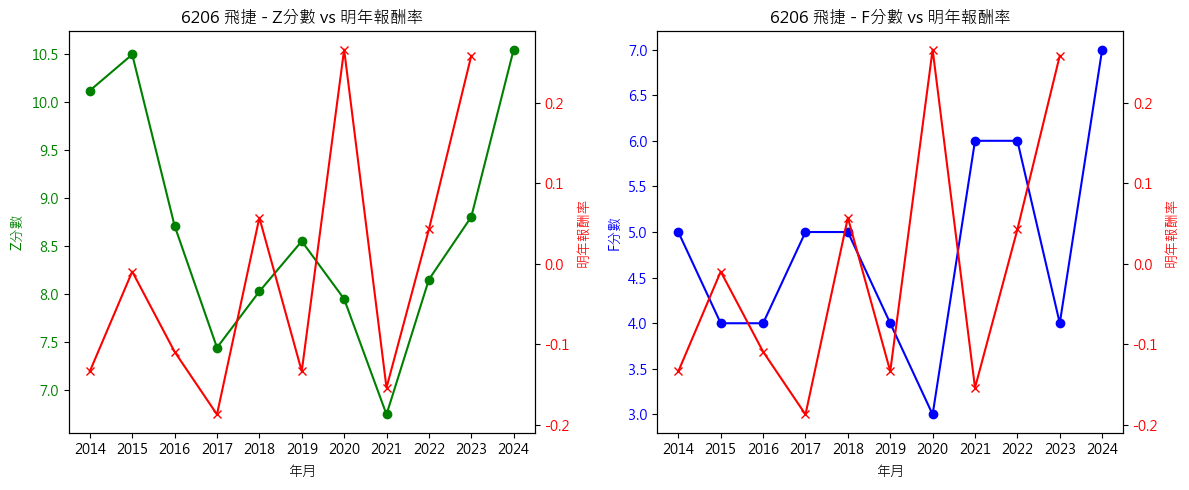

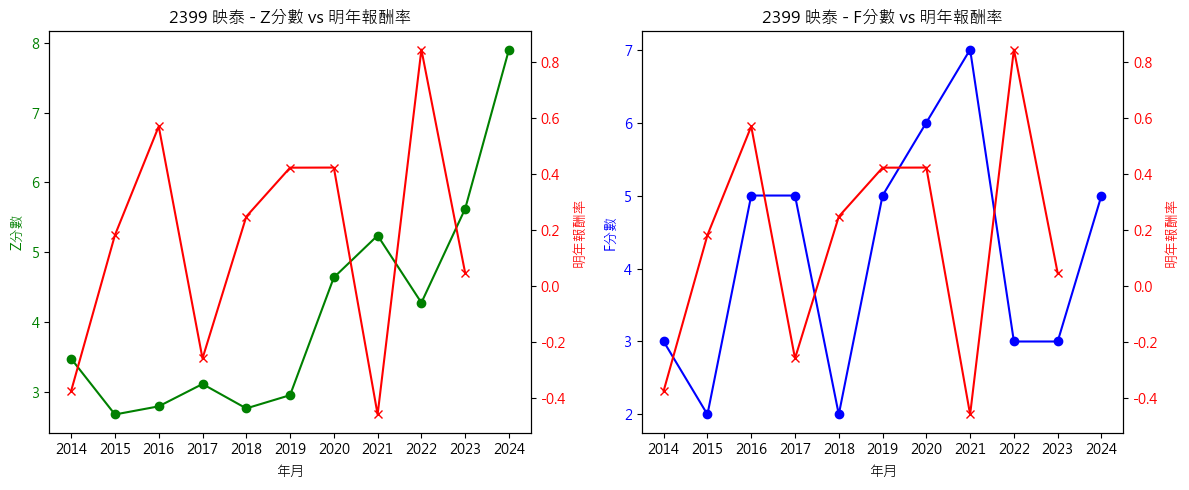

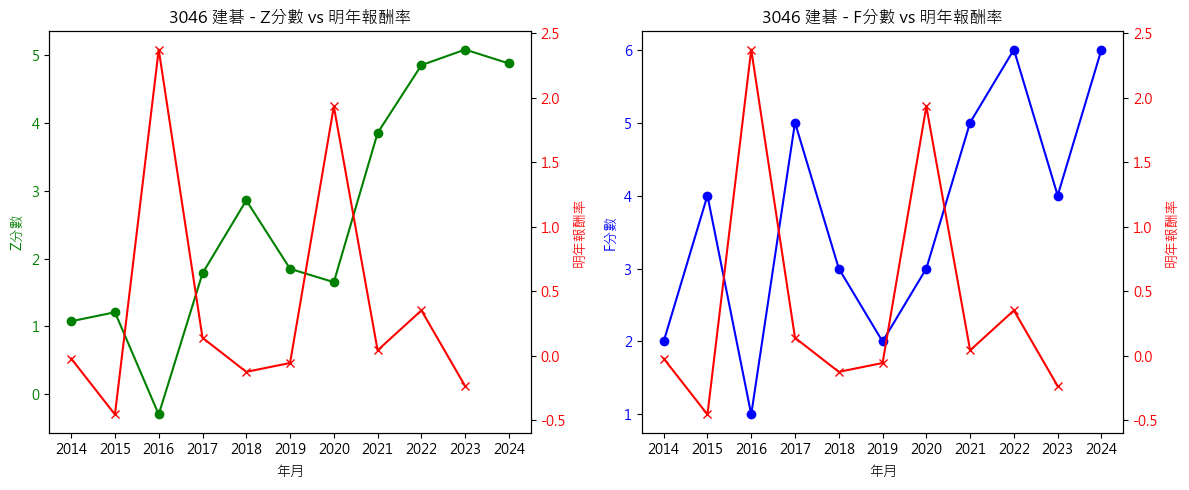

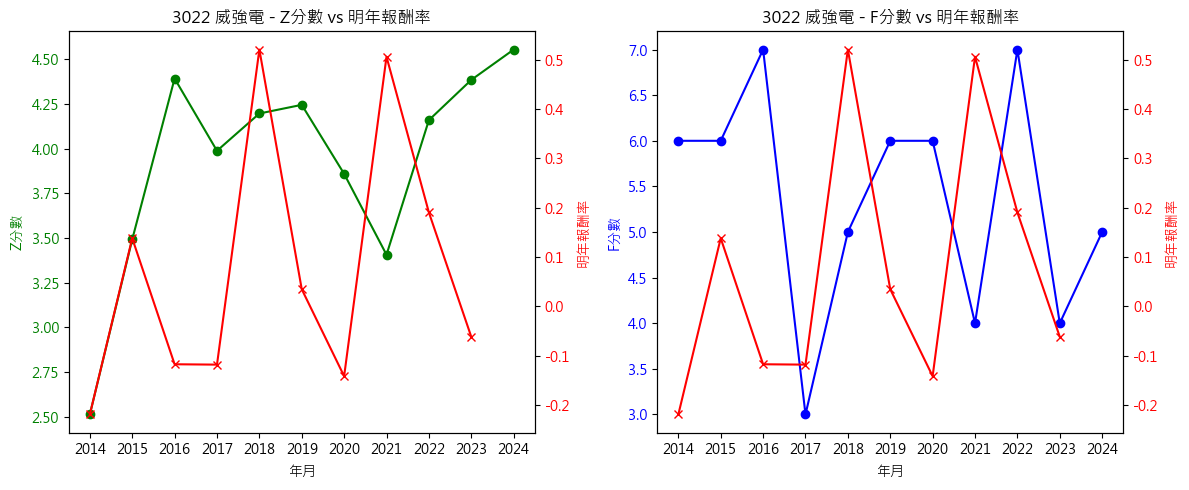

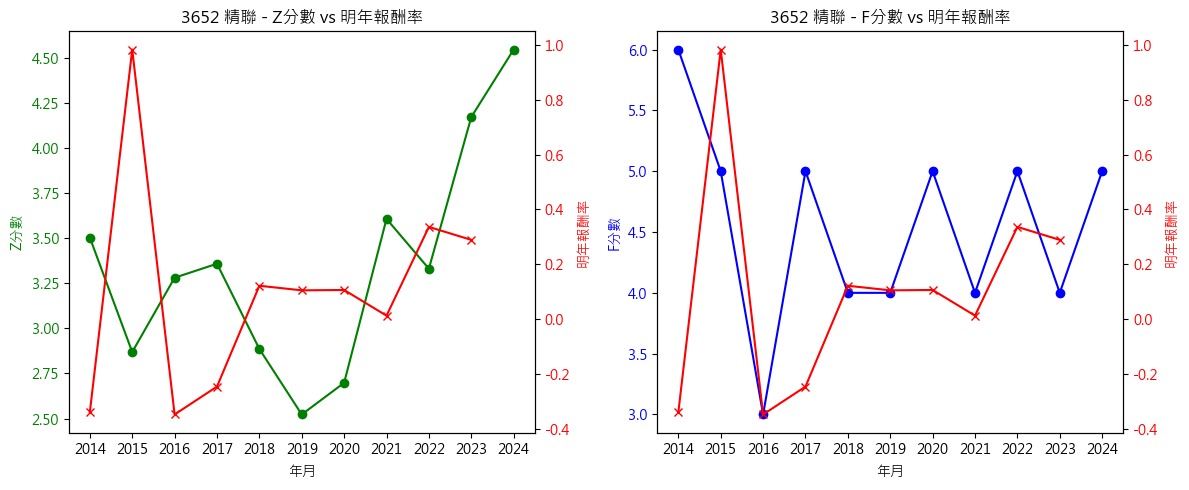

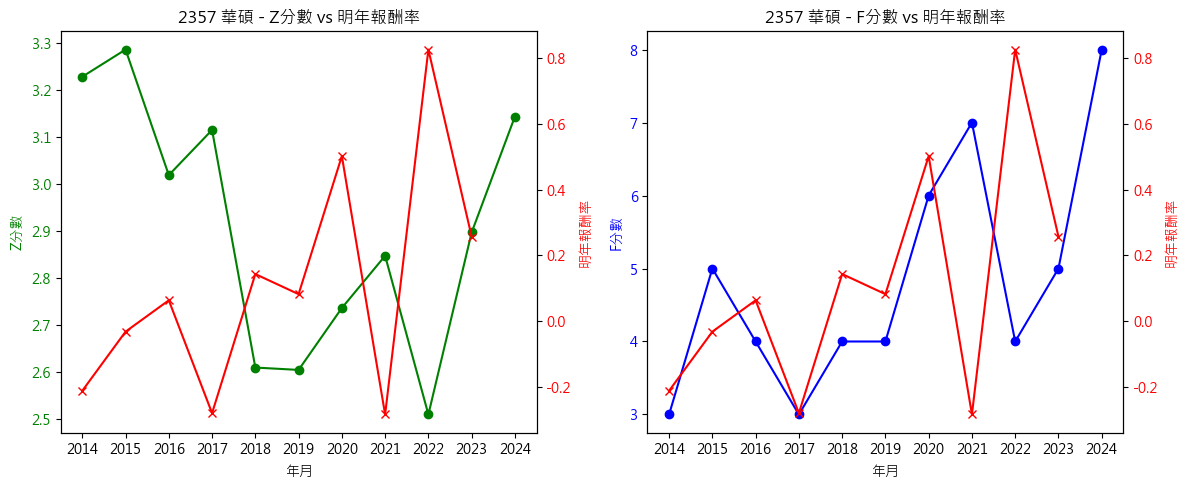

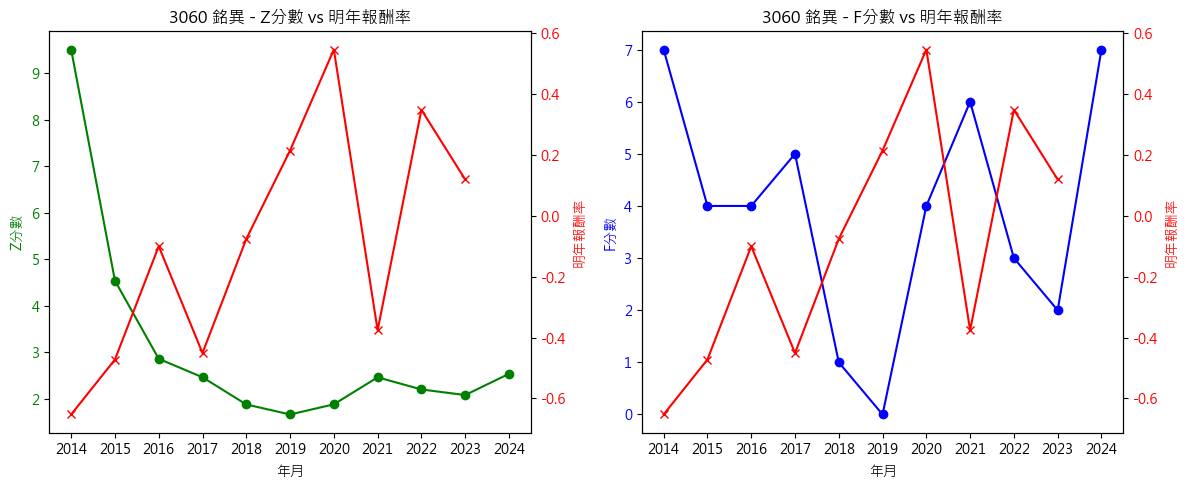

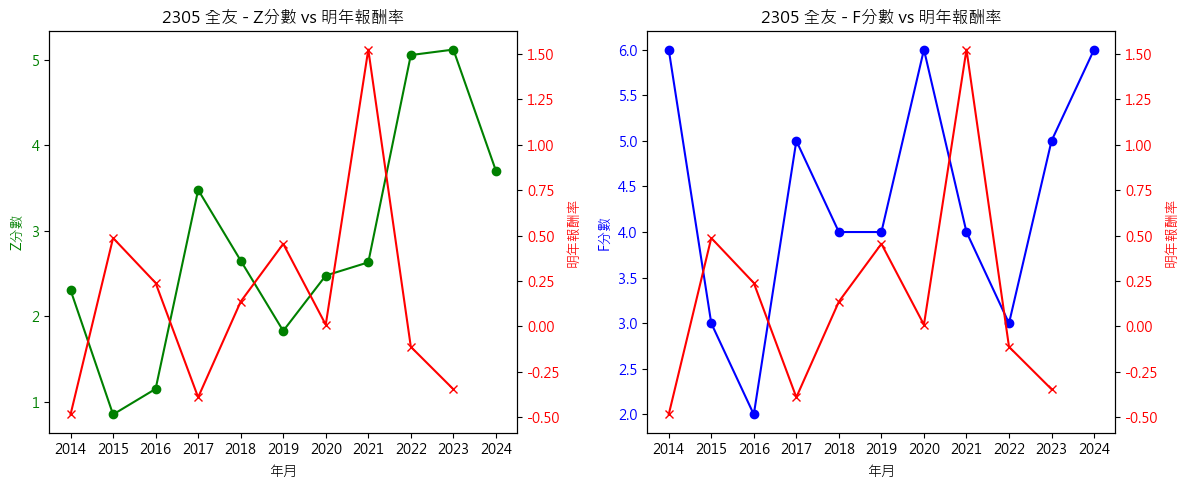

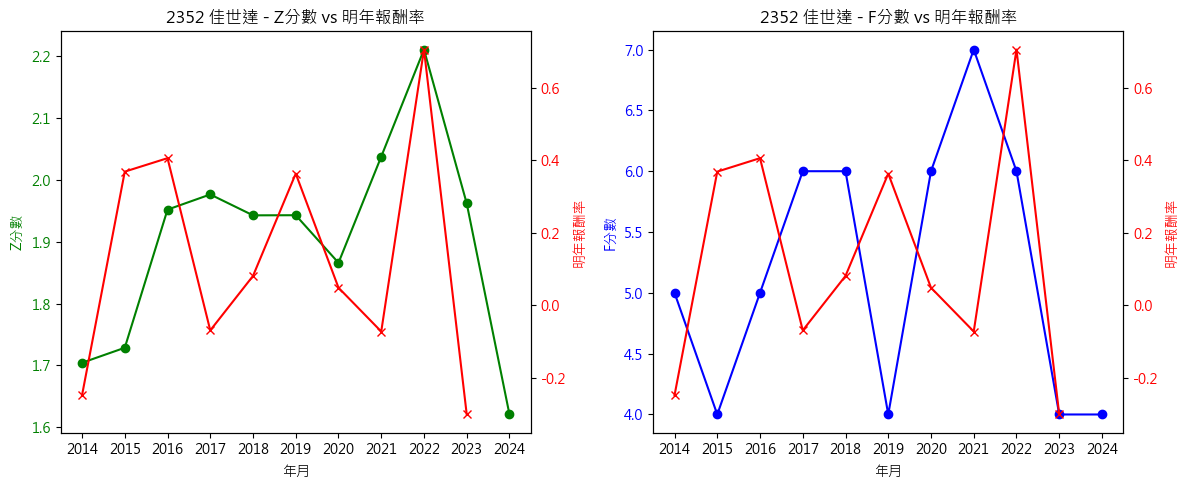

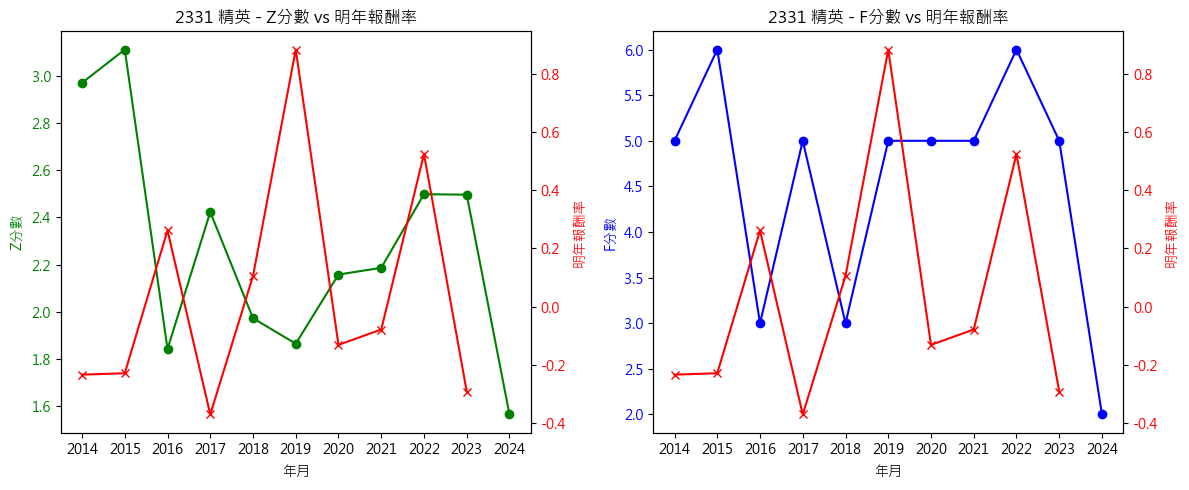

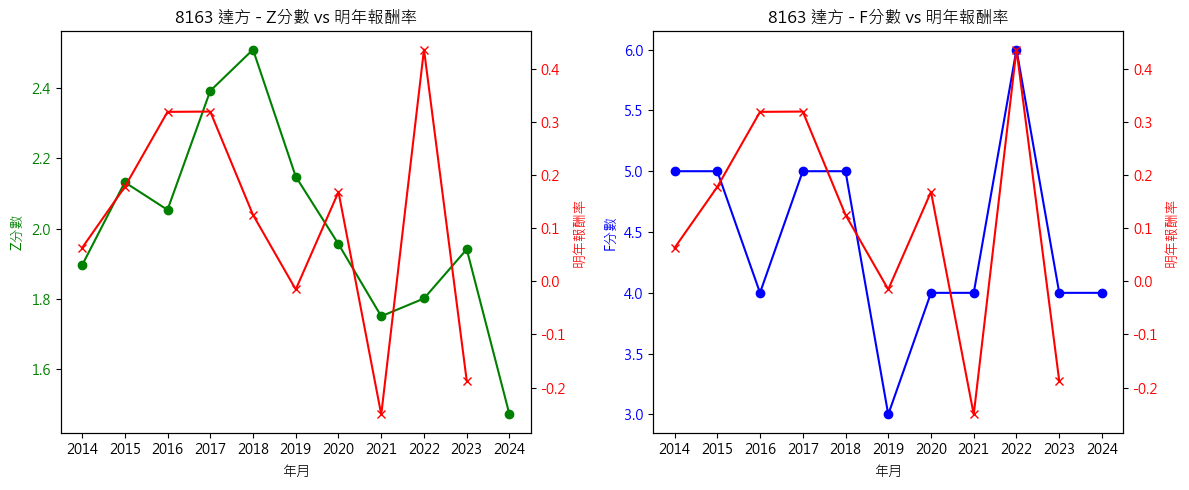

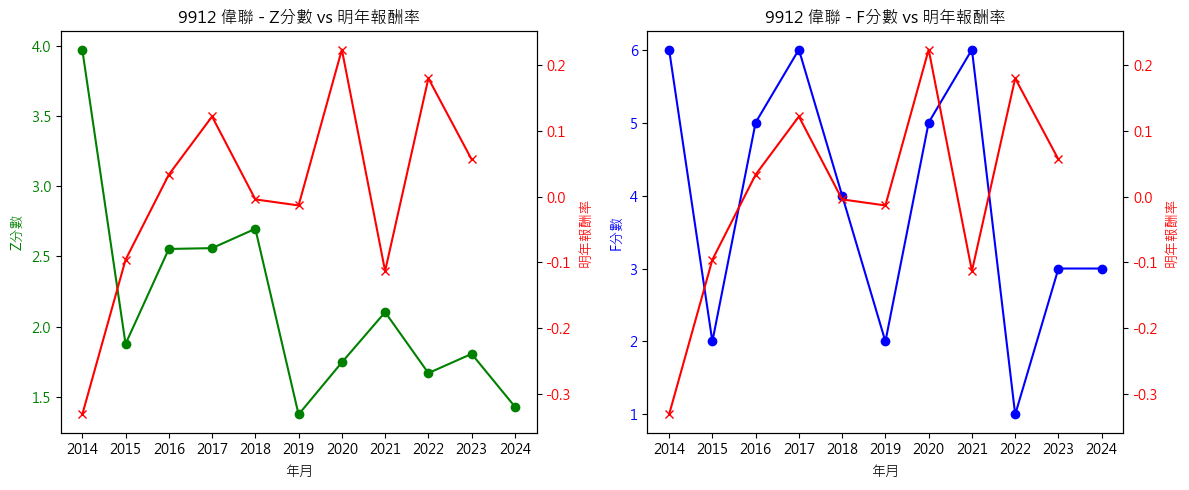

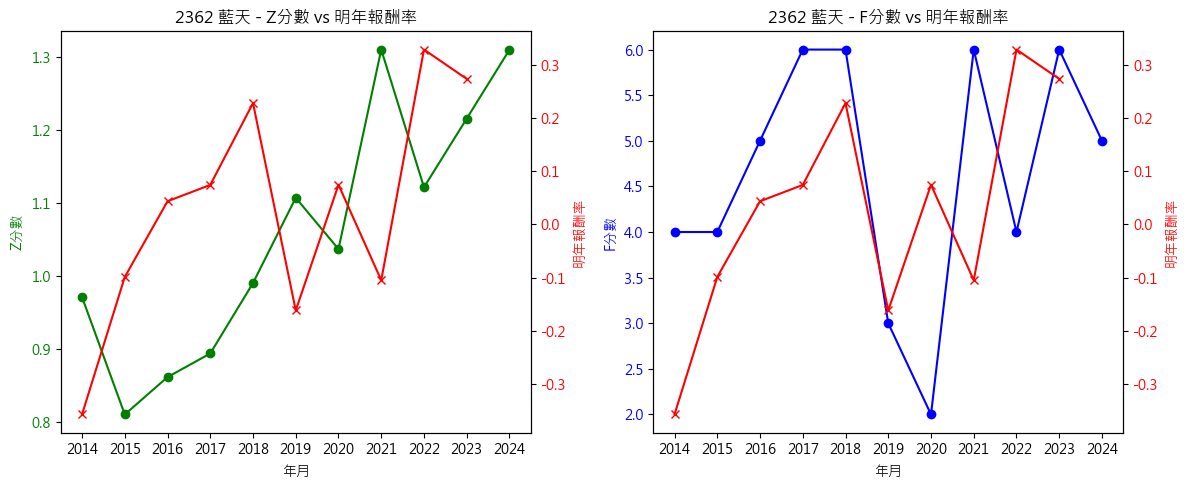

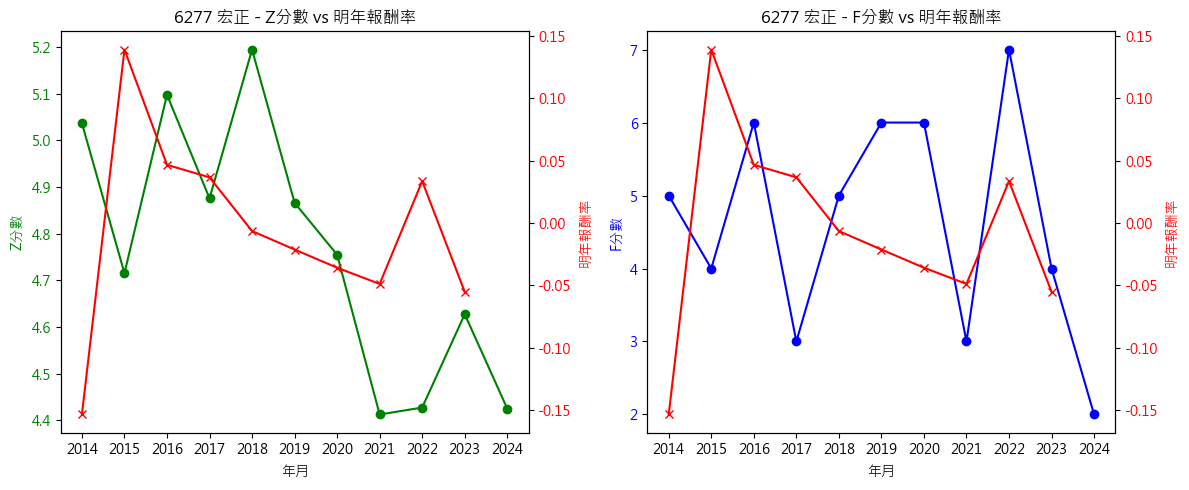

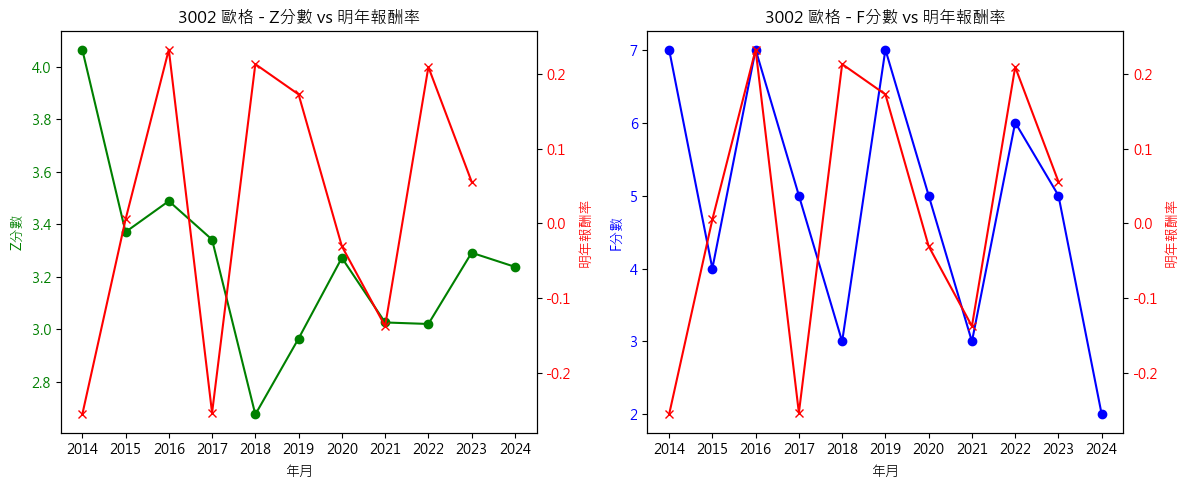

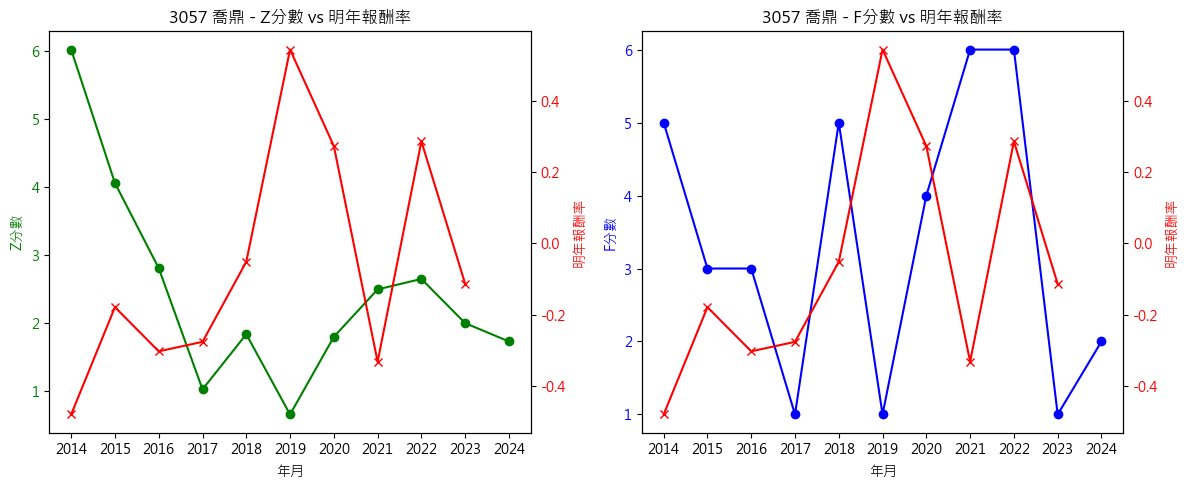

Excel 檔案已成功儲存！


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
import matplotlib.font_manager as fm
from io import BytesIO

# 設定字體（適用 Windows，如為 Mac/Linux 可改成 Heiti TC 或 Noto Sans CJK）
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False  # 避免負號變成方塊

# 創建圖片並插入到 Excel
def plot_and_insert_images(df, company_names, worksheet):
    for idx, company_name in enumerate(company_names):
        company_data = df[df['公司'] == company_name].copy()
        company_data['年月'] = company_data['年月'].astype(str)  # 確保時間為字串格式

        # 設置畫布大小
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # 繪製 Z分數 vs 明年報酬率
        ax1 = axes[0]
        ax1.plot(company_data['年月'], company_data['Z分數'], marker='o', label='Z分數', color='green')
        ax1.set_xlabel('年月')
        ax1.set_ylabel('Z分數', color='green')
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.set_title(f'{company_name} - Z分數 vs 明年報酬率')

        ax2 = ax1.twinx()
        ax2.plot(company_data['年月'], company_data['明年報酬率'], marker='x', label='明年報酬率', color='red')
        ax2.set_ylabel('明年報酬率', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # 繪製 F分數 vs 明年報酬率
        ax3 = axes[1]
        ax3.plot(company_data['年月'], company_data['F分數'], marker='o', label='F分數', color='blue')
        ax3.set_xlabel('年月')
        ax3.set_ylabel('F分數', color='blue')
        ax3.tick_params(axis='y', labelcolor='blue')
        ax3.set_title(f'{company_name} - F分數 vs 明年報酬率')

        ax4 = ax3.twinx()
        ax4.plot(company_data['年月'], company_data['明年報酬率'], marker='x', label='明年報酬率', color='red')
        ax4.set_ylabel('明年報酬率', color='red')
        ax4.tick_params(axis='y', labelcolor='red')

        plt.xticks(rotation=45)  # 避免標籤擠在一起
        plt.tight_layout()

        # 保存圖片至 BytesIO
        img_stream = BytesIO()
        plt.savefig(img_stream, format='png', dpi=100)  # 降低 DPI 以適應 Excel
        img_stream.seek(0)
        plt.show()  # 關閉圖表，避免記憶體占用

        # 插入圖片到 Excel，間隔 30 行，避免重疊
        img = openpyxl.drawing.image.Image(img_stream)
        img.width, img.height = 800, 300  # 設定圖片大小
        worksheet.add_image(img, f"A{(idx * 17) + 1}")  

# 保存資料並插入圖片至 Excel
def save_to_excel_with_images(excel_file, df, company_names):
    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name="merged_zf_score", index=False)

        workbook = writer.book
        worksheet = workbook.create_sheet("Images")

        # 插入圖片
        plot_and_insert_images(df, company_names, worksheet)

        # 保存其他表格
        z_score.to_excel(writer, sheet_name="z_score", index=False)
        z_score_return.to_excel(writer, sheet_name="z_score_Return", index=False)
        f_score.to_excel(writer, sheet_name="f_Score", index=False)
        f_score_return.to_excel(writer, sheet_name="f_score_Return", index=False)
        correlation_zf_score.reset_index().to_excel(writer, sheet_name="correlation_zf_score", index=False)

# 設置輸出 Excel 路徑
excel_file = r"E:\碩士\財務工程(二)\ZF_score_data_with_images3.xlsx"

# 設定公司列表
company_names = ['6206 飛捷', '2399 映泰', '3046 建碁', '3022 威強電', '3652 精聯', '2357 華碩', 
                 '3060 銘異', '2305 全友', '2352 佳世達', '2331 精英', '8163 達方', '9912 偉聯', 
                 '2362 藍天', '6277 宏正', '3002 歐格', '3057 喬鼎']

# 執行儲存
save_to_excel_with_images(excel_file, merged_zf_score, company_names)

print("Excel 檔案已成功儲存！")
